In [23]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
print 'success'

success


In [24]:
"""
This notebook implements the Logistic Regression in the 
"Cutting the Metropolis Hastings Budget" framework. 

The target distribution is the posterior for a logistic regression
model trained on MNIST dataset for classifying digits 7 vs 9. The 
dataset consisted of 12007 datapoints. 
"""

# get input data
mat = scipy.io.loadmat('minist7vs1.mat')
TrainLabel = mat['TrainLabel']
TrainLabel = np.reshape(TrainLabel, TrainLabel.shape[1],1)
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']
print TrainLabel.shape
print TrainImg.shape
print TrainImg[0].shape
TestLabel = np.reshape(TestLabel, TestLabel.shape[1],1)

(12007,)
(12007, 784)
(784,)


In [25]:
"""
Cutting the Metropolis Hastings Budget Method
"""
def random_walk_proposer(beta_t, sigmarw):
    """
    Input: beta_t  : previous parameters, 1-D array
           sigmarw : standard deviation, 1-D array
    """
    res = (np.random.multivariate_normal(beta_t, np.diag(sigmarw))).reshape((len(beta_t),))
    return res

def ll_data(beta_t, beta_n, X, Y):
    p_x_beta_t = 1/(1 + exp(-1* Y*np.dot(beta_t,X)))
    p_x_beta_n = 1/(1 + exp(-1* Y*np.dot(beta_n,X)))
    return log(p_x_beta_n) - log(p_x_beta_t)

def eval_U0(N):
    u = np.random.random()
    return 1/N*log(u)

def make_decision(l_list, N, U0):
    n = float(len(l_list))
    l_mean = sum(l_list)/n
    l_sq = ((np.array(l_list))**2).tolist()
    l_sq_mean = sum(l_sq)/n
    sl = sqrt((l_sq_mean - l_mean*l_mean)*n/(n-1))
    s = sl/sqrt(n) * sqrt(1 - (n-1)/(N-1))
    t_stats = abs((l_mean - U0)/s)
    delta = 1 - t.cdf(t_stats, n-1)
    return delta
    
def generate_parameter(beta_t, N, sigmarw, X, Y, batchsize, epsilon ):
    U0 = eval_U0(N)
    # generate new parameter
    P = len(X[0])
    sigma = (np.matlib.repmat(sigmarw, P,1)).reshape(P,)
    beta_n = random_walk_proposer(beta_t, sigma)
    
    # make decision
    l_list = []
    for i in range(batchsize):
        mid = ll_data(beta_t, beta_n, X[i], Y[i])
        l_list.append(mid)
    
    pos = batchsize
    delta = make_decision(l_list, N, U0)
    while (delta>epsilon) and (pos < N-1):
        mid = ll_data(beta_t, beta_n, X[pos], Y[pos])
        l_list.append(mid)
        pos = pos + 1
        delta = make_decision(l_list, N, U0)
    
    l_mean = sum(l_list)/float(len(l_list))
    if l_mean > U0:
        return (beta_n,1,pos)
    else:
        return (beta_t,0,pos)
    
def eval_cost(X,Y,beta):
    N = len(Y)
    sigmoid_accuracy = 1.0/(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    accuracy = len((np.where(sigmoid_accuracy>0.5))[0])
    sigmoid = -1.0 * np.log(1.0 + np.exp(-1.0 * Y * np.dot(beta, X.T)))
    cost = np.sum(sigmoid)
    """
    accuracy = 0
    cost = 0
    for i in range(N):
        sigmoid_accuracy = 1/(1 + exp(-1* Y[i]*np.dot(beta,X[i])))
        if sigmoid_accuracy > 0.5 :
            accuracy = accuracy + 1
        sigmoid = -1.0 * np.log(1 + exp(-1 * Y[i] * np.dot(beta, X[i])))
        cost = cost + sigmoid
    """
    return (cost/float(N), accuracy/float(N))
    
def train(X, Y, sigmarw, batchsize, epsilon, niter):
    N = len(Y) # number of total training data
    P = len(X[0]) # parameter dimension
    # beta_t = np.zeros(P)
    beta_t = np.random.rand(P)
    cost_list = []
    accept_pos = []
    accuracy_list = []
    for i in range(niter):
        print i
        index = np.random.permutation(N)
        X = X[index]
        Y = Y[index]
        (beta_t, mid, pos) = generate_parameter(beta_t, N, sigmarw, X,Y,batchsize,epsilon)
        (cost,accuracy) = eval_cost(TestImg, TestLabel, beta_t)
        cost_list.append(cost)
        accuracy_list.append(accuracy)
        accept_pos.append(pos)
    return (cost_list, accept_pos, accuracy_list)

X = TrainImg
Y = TrainLabel
sigmarw = 0.01
batchsize = 50
epsilon = 0.02
niter = 1000
(cost_list_xl, accept_pos_xl, accuracy_xl) = train(X, Y, sigmarw, batchsize, epsilon, niter)
print sum(accept_pos_xl)/float(len(accept_pos_xl))
cumulate_datasize_xl = [accept_pos_xl[0]]
cumulate_xl = accept_pos_xl[0]
for i in range(1,len(accept_pos_xl)):
    cumulate_xl += accept_pos_xl[i]
    cumulate_datasize_xl.append(cumulate_xl)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
# model class
# assume binary classes, 1 or -1
class Logistic:
    def __init__(self, num_featurs, proposer = None):
        # init the feature vector
        self.p = num_featurs
        self.proposer = proposer
    
    def ll(self, feature, X, Y):
        # return the log likelihood
        res = 0.0
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += np.log(1.0 + np.exp(-1.0 * Y[i] * np.sum(feature * X[i,:])))
        res = res * (-1.0)
        return res / n
    
    def delta(self, f_old, f_new, X, Y):
        res = self.ll(f_new, X, Y) - self.ll(f_old, X, Y)
        res += self.proposer.probGenerate(f_new, f_old, X, Y) # new -> old
        res = res - self.proposer.probGenerate(f_old, f_new, X, Y)  # old -> new
        return res
    
    def grad(self, feature, X, Y):
        # compute the grad of the ll
        [n, p] = X.shape
        n1 = Y.shape[0]
        res = np.zeros(self.p)
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += Y[i] * X[i,:] / (1 + np.exp(Y[i] * np.sum(feature * X[i,:])))
        return res/ n
    def predAcc(self, f, X, Y):
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        N_correct = 0
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5 and Y[i] == 1.0:
                N_correct += 1.0
            elif p < 0.5 and Y[i] == -1.0:
                N_correct += 1.0
        return N_correct / n
    def pred(self, f, X):
        a = X.shape
        if len(a) == 1:
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X)))
            if p > 0.5:
                return 1.0
            else:
                return -1.0
        else:
            [n, p] = X.shape
        res = np.zeros(n)
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5:
                res[i] = 1.0
            else:
                res[i] = -1.0
        return res

In [27]:
def randomPropose(beta, sig):
    p = len(beta)
    res = np.zeros(p)
    res = beta + np.random.normal(0,sig, p)
    return res

def randomData(miniBatchSize, im, label):
    n = label.shape[0]
    id = np.random.choice(n, miniBatchSize)
    img = im[id,:]
    idx = label[id]
    return (img, idx)
mat = scipy.io.loadmat('ecdf.mat')
x_l = mat['x_l'][0]
x_corr = mat['x_corr'][0]
ecdf_l = mat['ecdf_l'][0]
ecdf_corr = mat['ecdf_corr'][0]

In [28]:
class LangvanProposer:
    def __init__(self, model):
        self.m = model
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.step**0.5, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.step
        return res
        
class RandomWalkProposer:
    def update(self, beta, sig):
        p = len(beta)
        res = np.zeros(p)
        res = beta + np.random.normal(0,sig, p)
        return res
    def probGenerate(self, beta_old, beta_new, X, Y):
        return 1.0

class NoiseGradDescentProposer:
    def __init__(self, model, sd):
        self.m = model
        self.sd = sd
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.sd, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.sd**2
        return res

In [29]:
print TrainImg.shape, TrainLabel.shape

(12007, 784) (12007,)


In [34]:
# try the mini_batch
N = 2000
p = 784
beta = np.random.rand(p)
# beta = np.zeros(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 200
num_sd = 10
ll = []
acc = []
ll_full = np.zeros(N)
acc_full = np.zeros(N)
for i in range(N):
    sd_vect = np.zeros(num_sd)
    # sig = sig0 / (i + 1.0)**0.5
    sig = sig0
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        beta1 = rd.update(beta, sig)
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1])
    sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    sd_array[i] = sd_est
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = x_corr[bisect(ecdf_corr, u)]
    x_c = x_c *sd_est
    beta1 = rd.update(beta, sig)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1])
    if (delta + x_c > 0):
        beta = beta1
    data = randomData(200, TestImg, TestLabel)
    ll.append(logm.ll(beta, data[0], data[1]))
    acc.append(logm.predAcc(beta, data[0], data[1]))
    ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0:1000])
    acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0:1000])

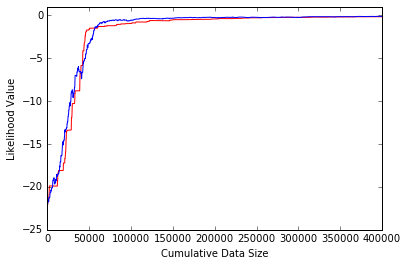

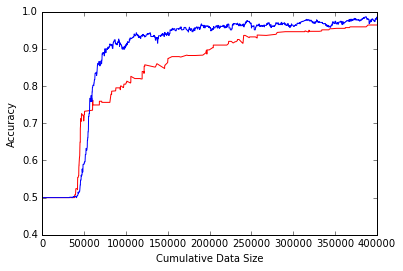

In [40]:
"""
compare the result
"""
# plot the likelihood with respect to the cumulative data size
plt.figure()
plt.plot(cumulate_datasize_xl,cost_list_xl,'r')
plt.hold(True)
x_ax = np.ones(N) * miniBatchSize
x_ax = np.cumsum(x_ax)
plt.plot(x_ax, ll_full, 'b')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Likelihood Value')
plt.axis([-1,400000,-25,1])
plt.show()

# plot the accuracy with respect to the cumulative data size
plt.figure()
plt.plot(cumulate_datasize_xl, accuracy_xl, 'r')
plt.hold(True)
plt.plot(x_ax, acc_full, 'b')
plt.xlabel('Cumulative Data Size')
plt.ylabel('Accuracy')
plt.axis([0, 400000 ,0.4, 1])
plt.show()

In [41]:
scipy.io.savemat('xl0.mat',{'cumulate_datasize_xl':cumulate_datasize_xl,'cost_list_xl':cost_list_xl, 'accuracy_xl':accuracy_xl})
scipy.io.savemat('hy0.mat',{'x_ax':x_ax, 'll_full':ll_full, 'acc_full':acc_full})